In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
!pip install scikeras

In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import plotly.express as px


**Data Handling and Cleaning**

In [38]:
df = pd.read_csv('/content/drive/My Drive/Mygoogle Folder/CustomerChurn_dataset.csv')

In [39]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [40]:
threshold = 0.3 * len(df)
df.dropna(thresh=threshold, axis=1, inplace=True)


In [41]:
nan_col = df.isnull().sum()
nan_col

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [42]:
nan_col.dtypes

dtype('int64')

In [43]:
df[nan_col.index].dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [44]:
# Select columns from 'df' based on the indices from 'nan_col' and filter by non-numeric data types
alpha_df = df[nan_col.index].select_dtypes(exclude=['number'])

# Count the number of missing values in 'alpha_df'
alpha_missing_values = alpha_df.isnull().sum()
alpha_missing_values

customerID          0
gender              0
Partner             0
Dependents          0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
TotalCharges        0
Churn               0
dtype: int64

In [45]:
# Define the columns to convert to integers and floats
int_columns = ["SeniorCitizen", "tenure"]
float_columns = ["MonthlyCharges", "TotalCharges"]

# Convert specified columns to integers
df[int_columns] = df[int_columns].astype(int)

# Replace empty strings with NaN in float columns
df[float_columns] = df[float_columns].replace(' ', np.nan)

# Convert the float columns, handling non-convertible values by coercing to NaN
for col in float_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Display the data types after conversion
converted_dtypes = df.dtypes
print(converted_dtypes)


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object


In [46]:
# Define columns for integer and float data type conversion
int_conversion_columns = ["SeniorCitizen", "tenure"]
float_conversion_columns = ["MonthlyCharges", "TotalCharges"]

# Convert specified columns to integer data type
df[int_conversion_columns] = df[int_conversion_columns].astype(int)

# Replace empty strings with NaN in float columns, handling missing data
df[float_conversion_columns] = df[float_conversion_columns].replace(' ', np.nan)

# Convert float columns to numeric values, handling non-convertible values by coercing to NaN
for float_col in float_conversion_columns:
    df[float_col] = pd.to_numeric(df[float_col], errors='coerce')

# Display the resulting data types after conversion
converted_data_types = df.dtypes
print(converted_data_types)


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object


In [47]:
# Fill missing values in the DataFrame with the median of each column
df = df.fillna(df.median())


<ipython-input-47-6faad7723245>:2: FutureWarning:

The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



In [48]:
# Extract columns from 'df' based on the indices in 'NullData' and filter for numeric data types
selected_numeric_columns = df[nan_col.index].select_dtypes(include='number')

# Count missing values in the selected numeric columns
missing_values_count = selected_numeric_columns.isnull().sum()

# Display the selected numeric columns and their missing value counts
print(selected_numeric_columns)
print("Missing Value Counts:")
print(missing_values_count)


      SeniorCitizen  tenure  MonthlyCharges  TotalCharges
0                 0       1           29.85         29.85
1                 0      34           56.95       1889.50
2                 0       2           53.85        108.15
3                 0      45           42.30       1840.75
4                 0       2           70.70        151.65
...             ...     ...             ...           ...
7038              0      24           84.80       1990.50
7039              0      72          103.20       7362.90
7040              0      11           29.60        346.45
7041              1       4           74.40        306.60
7042              0      66          105.65       6844.50

[7043 rows x 4 columns]
Missing Value Counts:
SeniorCitizen     0
tenure            0
MonthlyCharges    0
TotalCharges      0
dtype: int64


# Data Visualization

<ipython-input-49-30a12a8f1fc5>:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-49-30a12a8f1fc5>:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-49-30a12a8f1fc5>:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use ei

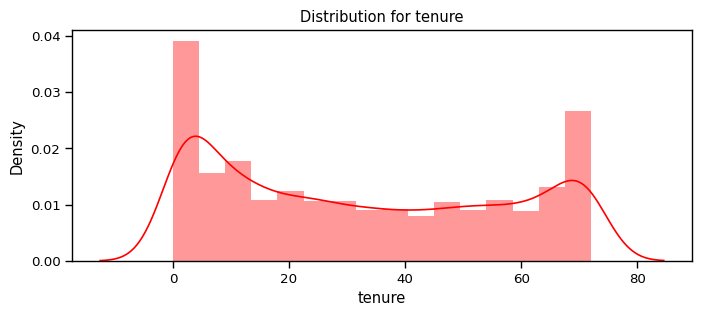

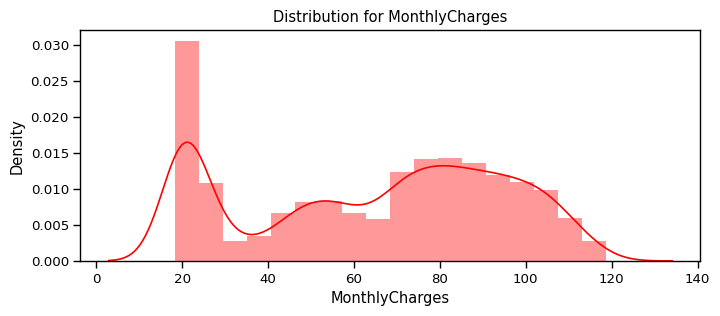

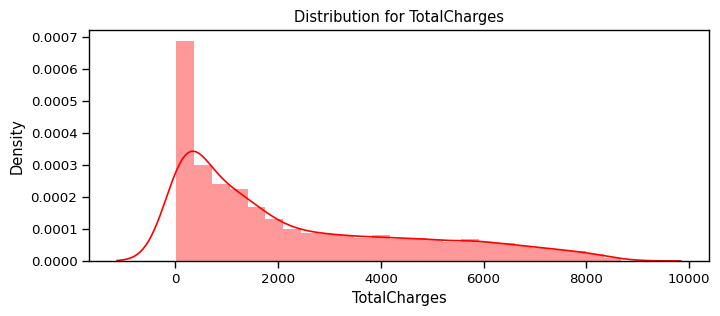

In [49]:

def distplot(feature, frame, color='r'):
    plt.figure(figsize=(8,3))
    plt.title("Distribution for {}".format(feature))
    ax = sns.distplot(frame[feature], color= color)
num_cols = ["tenure", 'MonthlyCharges', 'TotalCharges']
for feat in num_cols: distplot(feat, df)

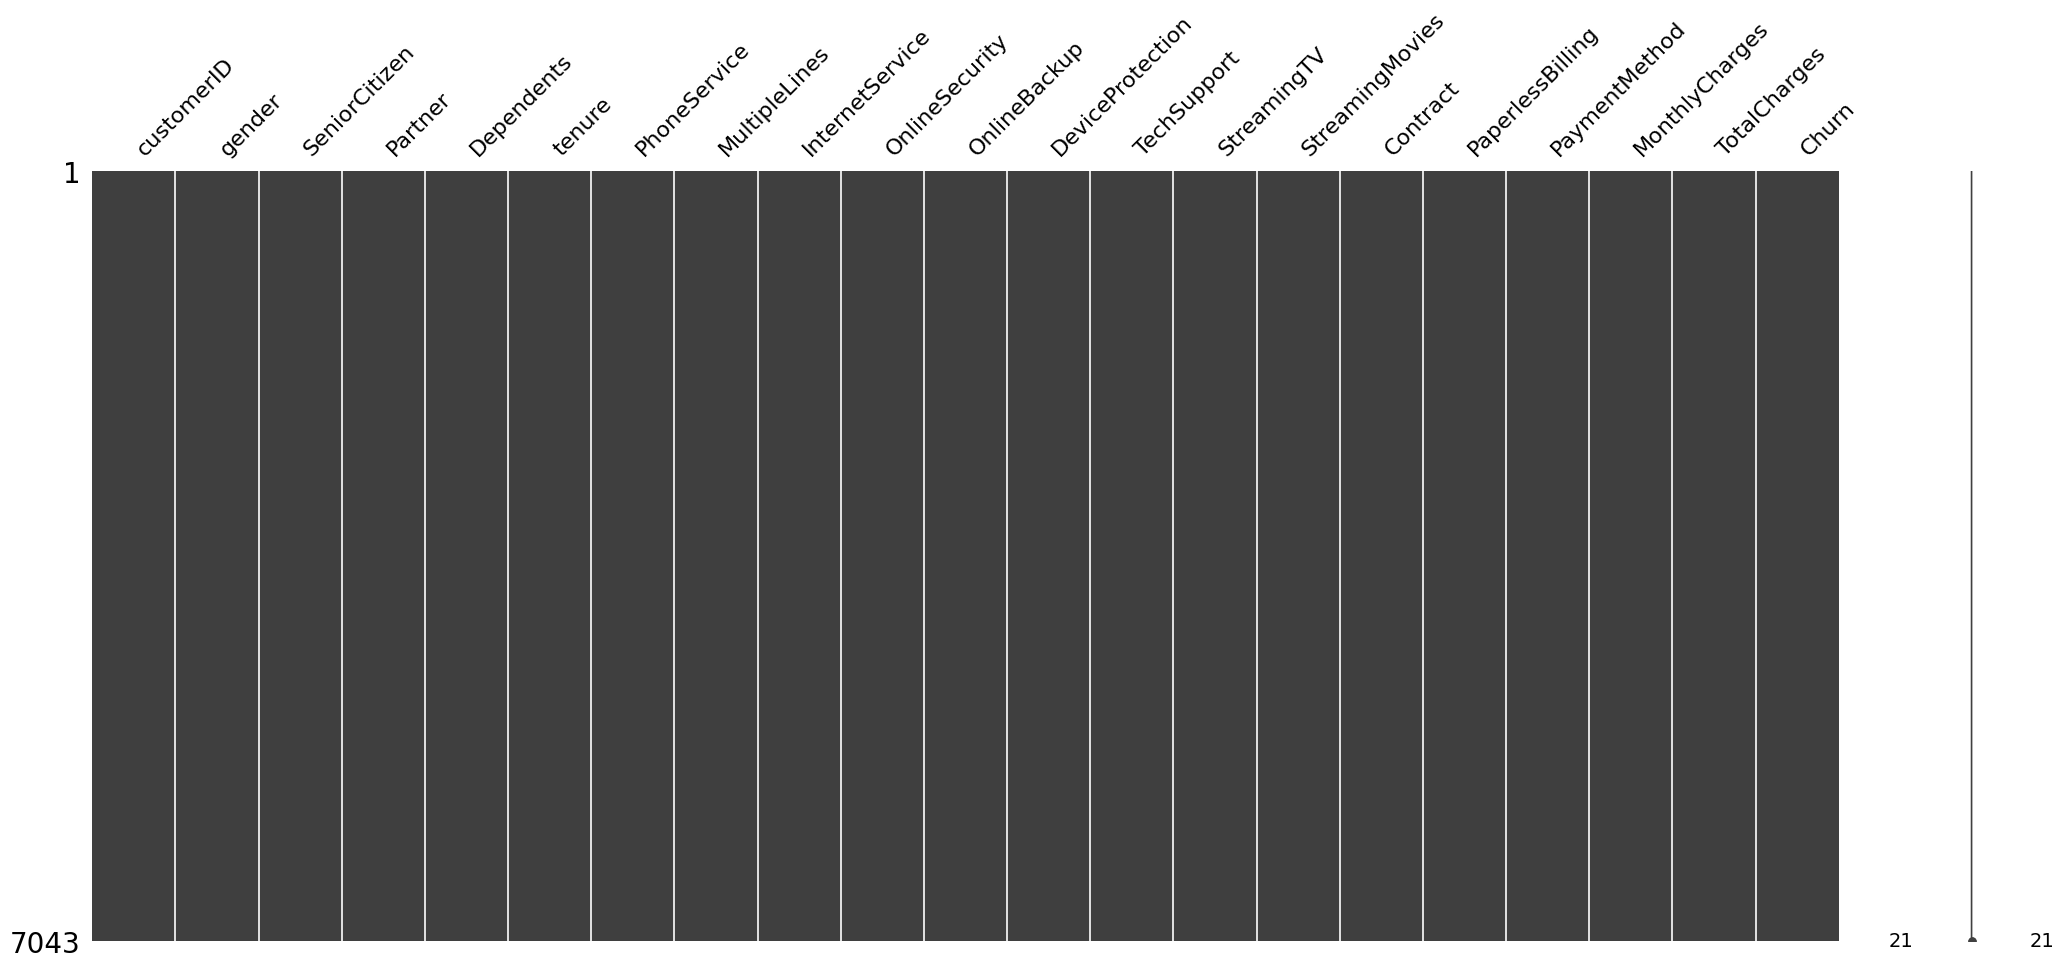

In [50]:
msno.matrix(df);

In [51]:
fig = px.histogram(df, x="Churn", color="Contract", barmode="group", title="<b>Customer contract distribution<b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

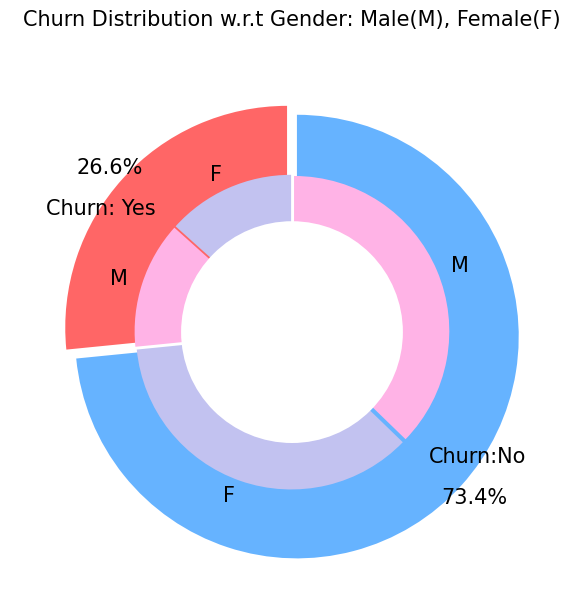

In [52]:
plt.figure(figsize=(6, 6))
labels =["Churn: Yes","Churn:No"]
values = [1869,5163]
labels_gender = ["F","M","F","M"]
sizes_gender = [939,930 , 2544,2619]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6']
explode = (0.3,0.3)
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Churn Distribution w.r.t Gender: Male(M), Female(F)', fontsize=15, y=1.1)

# show plot

plt.axis('equal')
plt.tight_layout()
plt.show()

In [53]:
g_labels = ['Male', 'Female']
c_labels = ['No', 'Yes']
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=g_labels, values=df['gender'].value_counts(), name="Gender"),
              1, 1)
fig.add_trace(go.Pie(labels=c_labels, values=df['Churn'].value_counts(), name="Churn"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)

fig.update_layout(
    title_text="Gender and Churn Distributions",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Gender', x=0.16, y=0.5, font_size=20, showarrow=False),
                 dict(text='Churn', x=0.84, y=0.5, font_size=20, showarrow=False)])
fig.show()

In [54]:
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}
fig = px.histogram(df, x="Churn", color="Dependents", barmode="group", title="<b>Dependents distribution</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [55]:
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
fig = px.histogram(df, x="Churn", color="Partner", barmode="group", title="<b>Chrun distribution w.r.t. Partners</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [56]:
fig = px.box(df, x='Churn', y = 'tenure')

# Update yaxis properties
fig.update_yaxes(title_text='Tenure (Months)', row=1, col=1)
# Update xaxis properties
fig.update_xaxes(title_text='Churn', row=1, col=1)

# Update size and title
fig.update_layout(autosize=True, width=750, height=600,
    title_font=dict(size=25, family='Courier'),
    title='<b>Tenure vs Churn</b>',
)

fig.show()

In [57]:
fig = go.Figure()

fig.add_trace(go.Bar(
  x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],
       ["Female", "Male", "Female", "Male"]],
  y = [965, 992, 219, 240],
  name = 'DSL',
))

fig.add_trace(go.Bar(
  x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],
       ["Female", "Male", "Female", "Male"]],
  y = [889, 910, 664, 633],
  name = 'Fiber optic',
))

fig.add_trace(go.Bar(
  x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],
       ["Female", "Male", "Female", "Male"]],
  y = [690, 717, 56, 57],
  name = 'No Internet',
))

fig.update_layout(title_text="<b>Churn Distribution w.r.t. Internet Service and Gender</b>")

fig.show()

In [58]:
fig = px.histogram(df, x="Churn", color="TechSupport",barmode="group",  title="<b>Chrun distribution w.r.t. TechSupport</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

<ipython-input-59-9321107cf963>:2: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-59-9321107cf963>:4: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




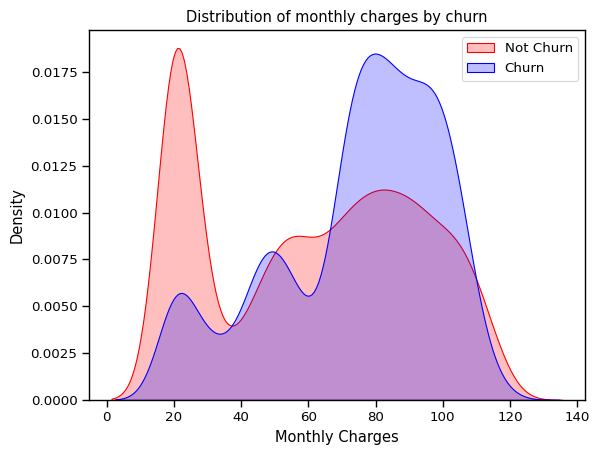

In [59]:
sns.set_context("paper",font_scale=1.1)
ax = sns.kdeplot(df.MonthlyCharges[(df["Churn"] == 'No') ],
                color="Red", shade = True);
ax = sns.kdeplot(df.MonthlyCharges[(df["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True);
ax.legend(["Not Churn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Monthly Charges');
ax.set_title('Distribution of monthly charges by churn');

<ipython-input-60-21edbc902f70>:1: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-60-21edbc902f70>:3: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




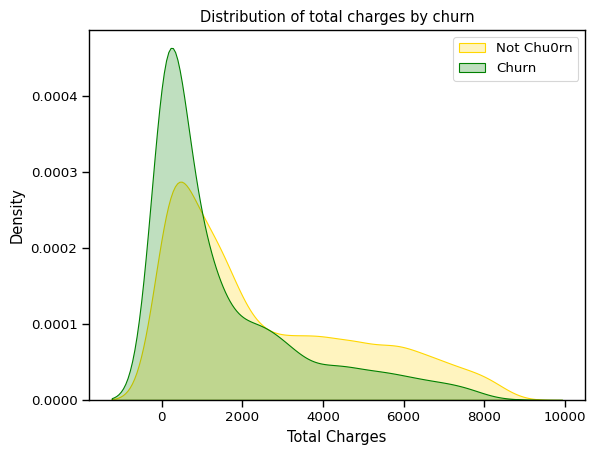

In [60]:
ax = sns.kdeplot(df.TotalCharges[(df["Churn"] == 'No') ],
                color="Gold", shade = True);
ax = sns.kdeplot(df.TotalCharges[(df["Churn"] == 'Yes') ],
                ax =ax, color="Green", shade= True);
ax.legend(["Not Chu0rn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Total Charges');
ax.set_title('Distribution of total charges by churn');

In [61]:
pip install plotly


In [62]:

labels = df['PaymentMethod'].unique()
values = df['PaymentMethod'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(title_text="<b>Payment Method Distribution</b>")
fig.show()

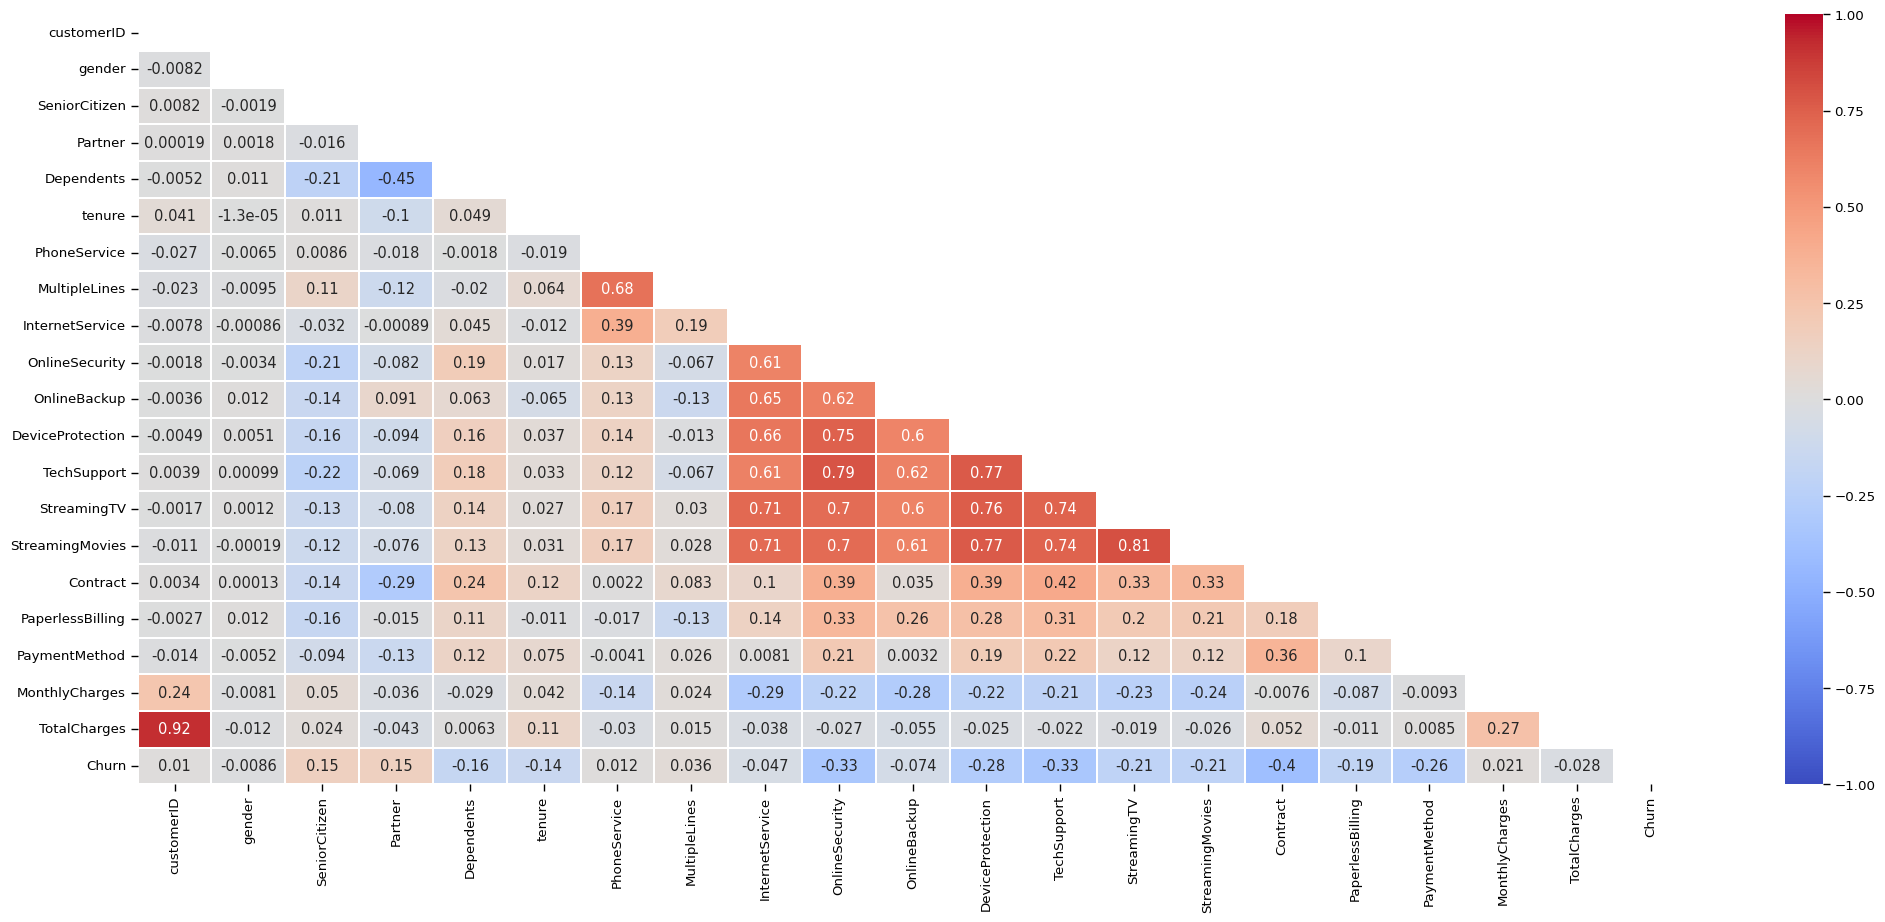

In [63]:


plt.figure(figsize=(25, 10))

corr = df.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

**Scaling and Label Encoding**

In [64]:
# Import the StandardScaler from the scikit-learn libraryfrom sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
data_scaler = StandardScaler()

# Create a copy of the numeric DataFrame for standardized data
standardized_data = selected_numeric_columns.copy()

# Use the StandardScaler to standardize the numeric columns
standardized_data[selected_numeric_columns.columns] = data_scaler.fit_transform(selected_numeric_columns[selected_numeric_columns.columns])

# Create a new DataFrame containing the standardized numeric data
numeric_scaled_df = standardized_data

# Display the DataFrame with the standardized numeric data
print(numeric_scaled_df)


      SeniorCitizen    tenure  MonthlyCharges  TotalCharges
0         -0.439916 -1.277445       -1.160323     -0.994242
1         -0.439916  0.066327       -0.259629     -0.173244
2         -0.439916 -1.236724       -0.362660     -0.959674
3         -0.439916  0.514251       -0.746535     -0.194766
4         -0.439916 -1.236724        0.197365     -0.940470
...             ...       ...             ...           ...
7038      -0.439916 -0.340876        0.665992     -0.128655
7039      -0.439916  1.613701        1.277533      2.243151
7040      -0.439916 -0.870241       -1.168632     -0.854469
7041       2.273159 -1.155283        0.320338     -0.872062
7042      -0.439916  1.369379        1.358961      2.014288

[7043 rows x 4 columns]


In [65]:
# Remove the 'customerId' column from the DataFrame
df = df.drop('customerID', axis=1)


In [66]:
# Remove numerical columns specified in 'num_col' from the DataFrame
categorical_columns = df.drop(selected_numeric_columns, axis=1)


In [67]:


# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Iterate through each column in the DataFrame
for column in categorical_columns.columns:
    # Check if the column contains categorical data
    if categorical_columns[column].dtype == 'object':
        # Apply label encoding to the categorical column
        categorical_columns[column] = label_encoder.fit_transform(categorical_columns[column])


In [68]:


# Combine the encoded categorical dataset with the original numerical columns
combined_df = pd.concat([categorical_columns, selected_numeric_columns], axis=1)
combined_df

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0,0,1,29.85,29.85
1,1,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0,0,34,56.95,1889.50
2,1,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1,0,2,53.85,108.15
3,1,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0,0,45,42.30,1840.75
4,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1,0,2,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,1,1,1,2,0,2,0,2,2,2,2,1,1,3,0,0,24,84.80,1990.50
7039,0,1,1,1,2,1,0,2,2,0,2,2,1,1,1,0,0,72,103.20,7362.90
7040,0,1,1,0,1,0,2,0,0,0,0,0,0,1,2,0,0,11,29.60,346.45
7041,1,1,0,1,2,1,0,0,0,0,0,0,0,1,3,1,1,4,74.40,306.60


**Performing feature importance and training the model**

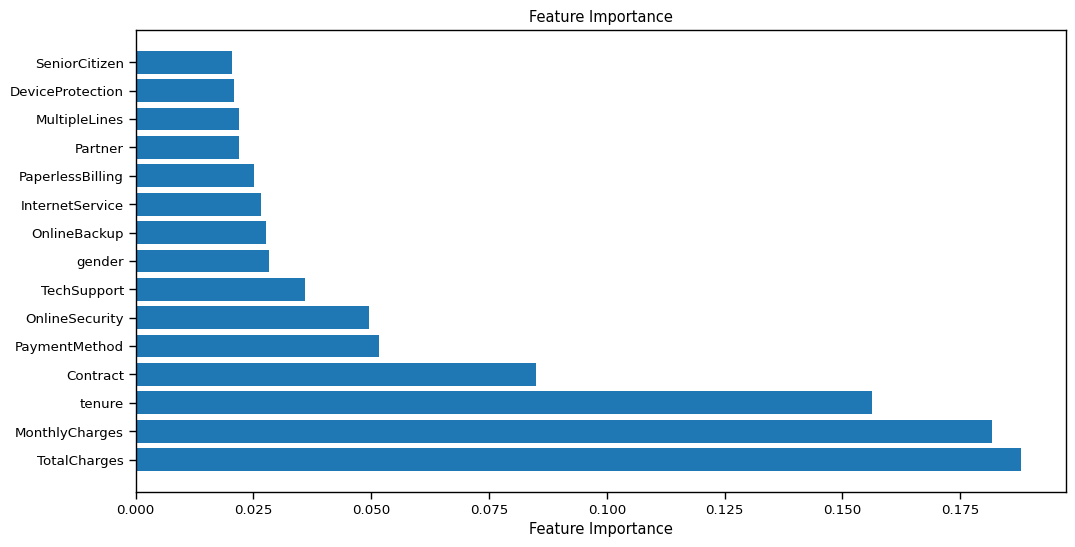

In [69]:


# Assuming 'target' is your target variable (e.g., 'Churn' column)
X = combined_df.drop('Churn', axis=1)
y = combined_df['Churn']

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Fit the classifier to your data
rf_classifier.fit(X, y)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame to store feature names and their importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
top_features = 15  # Change this value to plot a different number of top features
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'][:top_features], importance_df['Importance'][:top_features])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.show()
relevant_features=importance_df['Feature'][:top_features].values

In [70]:
X=combined_df[relevant_features]

In [71]:
# Split relevant features into training and testing sets
X_train,Xcb_dataset,y_train,ycb_dataset = train_test_split(X,y, test_size=0.2, random_state=42)

X_validation,X_test,y_validation,y_test = train_test_split(Xcb_dataset,ycb_dataset, test_size=0.2, random_state=42)


In [72]:


# Assuming X_train, y_train, X_validation, y_validation are available

# Input layer
input_layer = Input(shape=(X_train.shape[1],))

# Dense layers
dense_layer_1 = Dense(64, activation='relu')(input_layer)
dense_layer_2 = Dense(32, activation='relu')(dense_layer_1)

# Output layer
output_layer = Dense(1, activation='sigmoid')(dense_layer_2)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_validation, y_validation),
    verbose=0
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


9/9 [==============================] - 0s 3ms/step - loss: 5.0463 - accuracy: 0.4149
Test Loss: 5.046338081359863, Test Accuracy: 0.41489362716674805


In [73]:
!pip install scikeras

In [74]:

# Function to create the Keras model
def create_model(units=64):
    input_layer = Input(shape=(X_train.shape[1],))
    dense_layer_1 = Dense(units, activation='relu')(input_layer)
    dense_layer_2 = Dense(32, activation='relu')(dense_layer_1)
    output_layer = Dense(1, activation='sigmoid')(dense_layer_2)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create a KerasClassifier from Sci-Keras
keras_model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=True)

# Define hyperparameters for grid search
param_grid = {
    'batch_size': [16, 32, 64],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=keras_model, param_grid=param_grid, scoring=['accuracy', 'roc_auc'], refit='roc_auc', cv=3, verbose=True)
grid_result = grid_search.fit(X_train, y_train, validation_data=(X_validation, y_validation),verbose=True)

# Get the best parameters
best_params = grid_result.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = grid_result.best_estimator_
best_model_main = grid_result.best_estimator_.model

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
test_auc = roc_auc_score(y_test, y_pred)
test_accuracy = accuracy_score(y_test, (y_pred > 0.5).astype(int))

print(f'Test AUC: {test_auc}, Test Accuracy: {test_accuracy}')


Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



Epoch 1/10
235/235 [==============================] - 3s 7ms/step - loss: 6.5449 - accuracy: 0.6909 - val_loss: 3.0171 - val_accuracy: 0.7737
Epoch 2/10
235/235 [==============================] - 1s 5ms/step - loss: 2.2650 - accuracy: 0.7101 - val_loss: 1.0562 - val_accuracy: 0.7746
Epoch 3/10
235/235 [==============================] - 2s 7ms/step - loss: 2.4709 - accuracy: 0.7268 - val_loss: 2.5587 - val_accuracy: 0.7826
Epoch 4/10
235/235 [==============================] - 1s 6ms/step - loss: 1.2866 - accuracy: 0.7359 - val_loss: 1.2403 - val_accuracy: 0.5661
Epoch 5/10
235/235 [==============================] - 2s 10ms/step - loss: 1.2873 - accuracy: 0.7457 - val_loss: 2.8717 - val_accuracy: 0.7746
Epoch 6/10
235/235 [==============================] - 3s 13ms/step - loss: 1.5952 - accuracy: 0.7388 - val_loss: 0.4230 - val_accuracy: 0.7870
Epoch 7/10
235/235 [==============================] - 3s 12ms/step - loss: 1.2918 - accuracy: 0.7370 - val_loss: 2.5165 - val_accuracy: 0.7782
Epo

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



235/235 [==============================] - 4s 8ms/step - loss: 9.5315 - accuracy: 0.6797 - val_loss: 1.5248 - val_accuracy: 0.7844
Epoch 2/10
235/235 [==============================] - 3s 13ms/step - loss: 3.5102 - accuracy: 0.7199 - val_loss: 4.8614 - val_accuracy: 0.7808
Epoch 3/10
235/235 [==============================] - 2s 10ms/step - loss: 2.5743 - accuracy: 0.7401 - val_loss: 0.8197 - val_accuracy: 0.8012
Epoch 4/10
235/235 [==============================] - 3s 12ms/step - loss: 1.9189 - accuracy: 0.7396 - val_loss: 2.9905 - val_accuracy: 0.7835
Epoch 5/10
235/235 [==============================] - 2s 9ms/step - loss: 3.0595 - accuracy: 0.7303 - val_loss: 7.5597 - val_accuracy: 0.7755
Epoch 6/10
235/235 [==============================] - 2s 7ms/step - loss: 2.9496 - accuracy: 0.7412 - val_loss: 0.7267 - val_accuracy: 0.7711
Epoch 7/10
235/235 [==============================] - 2s 9ms/step - loss: 2.6972 - accuracy: 0.7356 - val_loss: 1.3816 - val_accuracy: 0.7649
Epoch 8/10
235

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



Epoch 1/10
235/235 [==============================] - 6s 12ms/step - loss: 6.6033 - accuracy: 0.6976 - val_loss: 5.0710 - val_accuracy: 0.7711
Epoch 2/10
235/235 [==============================] - 2s 10ms/step - loss: 2.9972 - accuracy: 0.7178 - val_loss: 0.6734 - val_accuracy: 0.7826
Epoch 3/10
235/235 [==============================] - 3s 14ms/step - loss: 3.0298 - accuracy: 0.7244 - val_loss: 1.8095 - val_accuracy: 0.7941
Epoch 4/10
235/235 [==============================] - 2s 9ms/step - loss: 3.2614 - accuracy: 0.7260 - val_loss: 3.1041 - val_accuracy: 0.5049
Epoch 5/10
235/235 [==============================] - 3s 12ms/step - loss: 3.2627 - accuracy: 0.7290 - val_loss: 2.8396 - val_accuracy: 0.7879
Epoch 6/10
235/235 [==============================] - 2s 7ms/step - loss: 1.8749 - accuracy: 0.7359 - val_loss: 7.6372 - val_accuracy: 0.7702
Epoch 7/10
235/235 [==============================] - 2s 9ms/step - loss: 1.2506 - accuracy: 0.7540 - val_loss: 0.7775 - val_accuracy: 0.7933
Ep

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



235/235 [==============================] - 2s 4ms/step - loss: 3.7091 - accuracy: 0.6808 - val_loss: 0.7494 - val_accuracy: 0.7054
Epoch 2/10
235/235 [==============================] - 1s 3ms/step - loss: 1.9584 - accuracy: 0.7236 - val_loss: 1.1058 - val_accuracy: 0.7959
Epoch 3/10
235/235 [==============================] - 1s 3ms/step - loss: 2.4188 - accuracy: 0.7149 - val_loss: 2.7605 - val_accuracy: 0.7791
Epoch 4/10
235/235 [==============================] - 1s 3ms/step - loss: 2.3785 - accuracy: 0.7178 - val_loss: 0.9755 - val_accuracy: 0.7870
Epoch 5/10
235/235 [==============================] - 1s 3ms/step - loss: 1.5969 - accuracy: 0.7319 - val_loss: 1.9236 - val_accuracy: 0.5324
Epoch 6/10
235/235 [==============================] - 1s 3ms/step - loss: 2.3462 - accuracy: 0.7138 - val_loss: 2.7953 - val_accuracy: 0.7755
Epoch 7/10
235/235 [==============================] - 1s 3ms/step - loss: 1.7002 - accuracy: 0.7409 - val_loss: 0.4653 - val_accuracy: 0.7986
Epoch 8/10
235/23

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



235/235 [==============================] - 3s 6ms/step - loss: 4.9908 - accuracy: 0.6810 - val_loss: 2.0421 - val_accuracy: 0.7808
Epoch 2/10
235/235 [==============================] - 1s 5ms/step - loss: 1.9075 - accuracy: 0.7178 - val_loss: 1.4602 - val_accuracy: 0.7853
Epoch 3/10
235/235 [==============================] - 1s 5ms/step - loss: 2.2369 - accuracy: 0.7303 - val_loss: 1.9212 - val_accuracy: 0.4871
Epoch 4/10
235/235 [==============================] - 1s 5ms/step - loss: 1.4454 - accuracy: 0.7471 - val_loss: 3.4573 - val_accuracy: 0.4747
Epoch 5/10
235/235 [==============================] - 1s 3ms/step - loss: 1.5678 - accuracy: 0.7415 - val_loss: 1.0612 - val_accuracy: 0.7862
Epoch 6/10
235/235 [==============================] - 1s 3ms/step - loss: 2.1437 - accuracy: 0.7372 - val_loss: 1.0127 - val_accuracy: 0.7897
Epoch 7/10
235/235 [==============================] - 1s 3ms/step - loss: 2.4558 - accuracy: 0.7311 - val_loss: 0.8437 - val_accuracy: 0.6451
Epoch 8/10
235/23

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



235/235 [==============================] - 2s 4ms/step - loss: 2.9774 - accuracy: 0.6904 - val_loss: 1.2145 - val_accuracy: 0.7640
Epoch 2/10
235/235 [==============================] - 1s 3ms/step - loss: 2.0501 - accuracy: 0.7186 - val_loss: 1.9358 - val_accuracy: 0.5049
Epoch 3/10
235/235 [==============================] - 1s 3ms/step - loss: 1.7046 - accuracy: 0.7340 - val_loss: 2.3463 - val_accuracy: 0.7684
Epoch 4/10
235/235 [==============================] - 1s 3ms/step - loss: 1.9486 - accuracy: 0.7351 - val_loss: 3.6058 - val_accuracy: 0.4783
Epoch 5/10
235/235 [==============================] - 1s 3ms/step - loss: 2.0343 - accuracy: 0.7279 - val_loss: 1.5908 - val_accuracy: 0.7906
Epoch 6/10
235/235 [==============================] - 1s 4ms/step - loss: 2.0404 - accuracy: 0.7364 - val_loss: 0.8213 - val_accuracy: 0.7001
Epoch 7/10
235/235 [==============================] - 1s 5ms/step - loss: 1.8537 - accuracy: 0.7362 - val_loss: 2.3676 - val_accuracy: 0.7835
Epoch 8/10
235/23

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



235/235 [==============================] - 2s 4ms/step - loss: 5.0103 - accuracy: 0.6667 - val_loss: 1.9668 - val_accuracy: 0.7755
Epoch 2/10
235/235 [==============================] - 1s 3ms/step - loss: 2.4428 - accuracy: 0.7034 - val_loss: 10.2527 - val_accuracy: 0.7675
Epoch 3/10
235/235 [==============================] - 1s 3ms/step - loss: 5.3443 - accuracy: 0.7021 - val_loss: 1.7813 - val_accuracy: 0.7773
Epoch 4/10
235/235 [==============================] - 1s 3ms/step - loss: 4.8475 - accuracy: 0.7053 - val_loss: 2.4804 - val_accuracy: 0.7906
Epoch 5/10
235/235 [==============================] - 1s 3ms/step - loss: 2.7174 - accuracy: 0.7162 - val_loss: 1.7012 - val_accuracy: 0.7835
Epoch 6/10
235/235 [==============================] - 1s 3ms/step - loss: 3.1929 - accuracy: 0.7154 - val_loss: 2.7997 - val_accuracy: 0.7906
Epoch 7/10
235/235 [==============================] - 1s 3ms/step - loss: 2.0963 - accuracy: 0.7351 - val_loss: 1.2199 - val_accuracy: 0.7924
Epoch 8/10
235/2

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



235/235 [==============================] - 4s 7ms/step - loss: 9.8056 - accuracy: 0.6797 - val_loss: 0.9779 - val_accuracy: 0.7933
Epoch 2/10
235/235 [==============================] - 1s 5ms/step - loss: 2.6700 - accuracy: 0.7231 - val_loss: 1.0311 - val_accuracy: 0.7879
Epoch 3/10
235/235 [==============================] - 1s 5ms/step - loss: 2.4750 - accuracy: 0.7404 - val_loss: 4.9749 - val_accuracy: 0.7702
Epoch 4/10
235/235 [==============================] - 1s 3ms/step - loss: 2.0699 - accuracy: 0.7500 - val_loss: 4.1782 - val_accuracy: 0.7693
Epoch 5/10
235/235 [==============================] - 1s 3ms/step - loss: 3.1113 - accuracy: 0.7306 - val_loss: 0.9835 - val_accuracy: 0.7489
Epoch 6/10
235/235 [==============================] - 1s 3ms/step - loss: 1.9859 - accuracy: 0.7370 - val_loss: 0.6844 - val_accuracy: 0.7498
Epoch 7/10
235/235 [==============================] - 1s 3ms/step - loss: 3.1542 - accuracy: 0.7295 - val_loss: 3.1152 - val_accuracy: 0.7888
Epoch 8/10
235/23

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



235/235 [==============================] - 2s 4ms/step - loss: 6.1214 - accuracy: 0.6257 - val_loss: 7.6011 - val_accuracy: 0.7329
Epoch 2/10
235/235 [==============================] - 1s 3ms/step - loss: 2.1239 - accuracy: 0.7095 - val_loss: 0.6243 - val_accuracy: 0.7693
Epoch 3/10
235/235 [==============================] - 1s 5ms/step - loss: 1.6085 - accuracy: 0.7149 - val_loss: 1.3787 - val_accuracy: 0.7862
Epoch 4/10
235/235 [==============================] - 3s 12ms/step - loss: 2.2263 - accuracy: 0.7228 - val_loss: 2.4736 - val_accuracy: 0.7799
Epoch 5/10
235/235 [==============================] - 3s 11ms/step - loss: 2.1187 - accuracy: 0.7279 - val_loss: 0.8131 - val_accuracy: 0.7906
Epoch 6/10
235/235 [==============================] - 1s 5ms/step - loss: 2.0490 - accuracy: 0.7364 - val_loss: 0.7727 - val_accuracy: 0.7915
Epoch 7/10
235/235 [==============================] - 1s 4ms/step - loss: 1.7239 - accuracy: 0.7364 - val_loss: 2.7726 - val_accuracy: 0.7666
Epoch 8/10
235/

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



118/118 [==============================] - 2s 6ms/step - loss: 21.8765 - accuracy: 0.6712 - val_loss: 0.7467 - val_accuracy: 0.7826
Epoch 2/10
118/118 [==============================] - 0s 4ms/step - loss: 1.1526 - accuracy: 0.7399 - val_loss: 0.5779 - val_accuracy: 0.6983
Epoch 3/10
118/118 [==============================] - 0s 4ms/step - loss: 1.4716 - accuracy: 0.7210 - val_loss: 0.8043 - val_accuracy: 0.7817
Epoch 4/10
118/118 [==============================] - 0s 3ms/step - loss: 1.9423 - accuracy: 0.7178 - val_loss: 0.5070 - val_accuracy: 0.7808
Epoch 5/10
118/118 [==============================] - 0s 4ms/step - loss: 2.3389 - accuracy: 0.7236 - val_loss: 1.5476 - val_accuracy: 0.7897
Epoch 6/10
118/118 [==============================] - 0s 4ms/step - loss: 1.0319 - accuracy: 0.7420 - val_loss: 1.2522 - val_accuracy: 0.7853
Epoch 7/10
118/118 [==============================] - 1s 4ms/step - loss: 1.6859 - accuracy: 0.7282 - val_loss: 1.0952 - val_accuracy: 0.7915
Epoch 8/10
118/1

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



118/118 [==============================] - 3s 8ms/step - loss: 2.7513 - accuracy: 0.6904 - val_loss: 1.9542 - val_accuracy: 0.7746
Epoch 2/10
118/118 [==============================] - 1s 6ms/step - loss: 1.9297 - accuracy: 0.7362 - val_loss: 1.8596 - val_accuracy: 0.5209
Epoch 3/10
118/118 [==============================] - 1s 6ms/step - loss: 1.8201 - accuracy: 0.7319 - val_loss: 0.5411 - val_accuracy: 0.7675
Epoch 4/10
118/118 [==============================] - 1s 6ms/step - loss: 1.5637 - accuracy: 0.7303 - val_loss: 0.5927 - val_accuracy: 0.7001
Epoch 5/10
118/118 [==============================] - 1s 6ms/step - loss: 1.6522 - accuracy: 0.7391 - val_loss: 1.7080 - val_accuracy: 0.7826
Epoch 6/10
118/118 [==============================] - 1s 5ms/step - loss: 2.4068 - accuracy: 0.7316 - val_loss: 1.5188 - val_accuracy: 0.7933
Epoch 7/10
118/118 [==============================] - 0s 3ms/step - loss: 1.5375 - accuracy: 0.7388 - val_loss: 0.6489 - val_accuracy: 0.7879
Epoch 8/10
118/11

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



118/118 [==============================] - 1s 6ms/step - loss: 3.5329 - accuracy: 0.6723 - val_loss: 0.7755 - val_accuracy: 0.6451
Epoch 2/10
118/118 [==============================] - 0s 3ms/step - loss: 1.9835 - accuracy: 0.7125 - val_loss: 1.2555 - val_accuracy: 0.7746
Epoch 3/10
118/118 [==============================] - 0s 3ms/step - loss: 1.3125 - accuracy: 0.7239 - val_loss: 1.0829 - val_accuracy: 0.5839
Epoch 4/10
118/118 [==============================] - 0s 3ms/step - loss: 1.3105 - accuracy: 0.7324 - val_loss: 1.1287 - val_accuracy: 0.7897
Epoch 5/10
118/118 [==============================] - 1s 5ms/step - loss: 1.2917 - accuracy: 0.7359 - val_loss: 0.6685 - val_accuracy: 0.6930
Epoch 6/10
118/118 [==============================] - 1s 5ms/step - loss: 1.1737 - accuracy: 0.7441 - val_loss: 0.5560 - val_accuracy: 0.7560
Epoch 7/10
118/118 [==============================] - 1s 5ms/step - loss: 1.3505 - accuracy: 0.7463 - val_loss: 0.6664 - val_accuracy: 0.7924
Epoch 8/10
118/11

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



118/118 [==============================] - 1s 5ms/step - loss: 4.3764 - accuracy: 0.6882 - val_loss: 1.1083 - val_accuracy: 0.7817
Epoch 2/10
118/118 [==============================] - 0s 4ms/step - loss: 1.1578 - accuracy: 0.7242 - val_loss: 1.0589 - val_accuracy: 0.5989
Epoch 3/10
118/118 [==============================] - 0s 3ms/step - loss: 1.1012 - accuracy: 0.7343 - val_loss: 1.5435 - val_accuracy: 0.7764
Epoch 4/10
118/118 [==============================] - 0s 3ms/step - loss: 1.5460 - accuracy: 0.7287 - val_loss: 2.6919 - val_accuracy: 0.7782
Epoch 5/10
118/118 [==============================] - 0s 3ms/step - loss: 2.6955 - accuracy: 0.7220 - val_loss: 0.8887 - val_accuracy: 0.7853
Epoch 6/10
118/118 [==============================] - 0s 3ms/step - loss: 1.1106 - accuracy: 0.7439 - val_loss: 0.5808 - val_accuracy: 0.6974
Epoch 7/10
118/118 [==============================] - 0s 3ms/step - loss: 1.7364 - accuracy: 0.7316 - val_loss: 0.5191 - val_accuracy: 0.8021
Epoch 8/10
118/11

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



118/118 [==============================] - 1s 5ms/step - loss: 6.5535 - accuracy: 0.6813 - val_loss: 1.6012 - val_accuracy: 0.7782
Epoch 2/10
118/118 [==============================] - 0s 3ms/step - loss: 2.3883 - accuracy: 0.7154 - val_loss: 1.2248 - val_accuracy: 0.7826
Epoch 3/10
118/118 [==============================] - 0s 3ms/step - loss: 2.4480 - accuracy: 0.7401 - val_loss: 3.3903 - val_accuracy: 0.7764
Epoch 4/10
118/118 [==============================] - 0s 3ms/step - loss: 3.9926 - accuracy: 0.7151 - val_loss: 8.8616 - val_accuracy: 0.7728
Epoch 5/10
118/118 [==============================] - 0s 3ms/step - loss: 2.8791 - accuracy: 0.7322 - val_loss: 2.2497 - val_accuracy: 0.7755
Epoch 6/10
118/118 [==============================] - 0s 3ms/step - loss: 2.2251 - accuracy: 0.7322 - val_loss: 1.5679 - val_accuracy: 0.7666
Epoch 7/10
118/118 [==============================] - 0s 3ms/step - loss: 2.3943 - accuracy: 0.7335 - val_loss: 0.7432 - val_accuracy: 0.7906
Epoch 8/10
118/11

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



118/118 [==============================] - 2s 8ms/step - loss: 2.5354 - accuracy: 0.7087 - val_loss: 0.4588 - val_accuracy: 0.7711
Epoch 2/10
118/118 [==============================] - 1s 5ms/step - loss: 1.0885 - accuracy: 0.7457 - val_loss: 0.6727 - val_accuracy: 0.7933
Epoch 3/10
118/118 [==============================] - 1s 6ms/step - loss: 1.1075 - accuracy: 0.7489 - val_loss: 1.1953 - val_accuracy: 0.5945
Epoch 4/10
118/118 [==============================] - 1s 4ms/step - loss: 1.2574 - accuracy: 0.7428 - val_loss: 1.4470 - val_accuracy: 0.5705
Epoch 5/10
118/118 [==============================] - 0s 4ms/step - loss: 1.3883 - accuracy: 0.7479 - val_loss: 0.7975 - val_accuracy: 0.7862
Epoch 6/10
118/118 [==============================] - 0s 4ms/step - loss: 1.2165 - accuracy: 0.7386 - val_loss: 1.0355 - val_accuracy: 0.7862
Epoch 7/10
118/118 [==============================] - 0s 3ms/step - loss: 2.0013 - accuracy: 0.7425 - val_loss: 2.2717 - val_accuracy: 0.7853
Epoch 8/10
118/11

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



118/118 [==============================] - 1s 5ms/step - loss: 13.4860 - accuracy: 0.6432 - val_loss: 1.2539 - val_accuracy: 0.7764
Epoch 2/10
118/118 [==============================] - 0s 3ms/step - loss: 1.3158 - accuracy: 0.6944 - val_loss: 2.5786 - val_accuracy: 0.7746
Epoch 3/10
118/118 [==============================] - 1s 5ms/step - loss: 0.9484 - accuracy: 0.7223 - val_loss: 0.7150 - val_accuracy: 0.7817
Epoch 4/10
118/118 [==============================] - 1s 6ms/step - loss: 0.8992 - accuracy: 0.7279 - val_loss: 0.4840 - val_accuracy: 0.7462
Epoch 5/10
118/118 [==============================] - 1s 6ms/step - loss: 0.9762 - accuracy: 0.7399 - val_loss: 1.4138 - val_accuracy: 0.7870
Epoch 6/10
118/118 [==============================] - 1s 5ms/step - loss: 0.8133 - accuracy: 0.7362 - val_loss: 0.5811 - val_accuracy: 0.7950
Epoch 7/10
118/118 [==============================] - 1s 6ms/step - loss: 0.6852 - accuracy: 0.7511 - val_loss: 0.4483 - val_accuracy: 0.7853
Epoch 8/10
118/1

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



118/118 [==============================] - 2s 5ms/step - loss: 4.9978 - accuracy: 0.7053 - val_loss: 0.9221 - val_accuracy: 0.7711
Epoch 2/10
118/118 [==============================] - 0s 3ms/step - loss: 2.6457 - accuracy: 0.7244 - val_loss: 1.5574 - val_accuracy: 0.7924
Epoch 3/10
118/118 [==============================] - 0s 3ms/step - loss: 2.2641 - accuracy: 0.7295 - val_loss: 2.9082 - val_accuracy: 0.7649
Epoch 4/10
118/118 [==============================] - 0s 3ms/step - loss: 2.6721 - accuracy: 0.7207 - val_loss: 1.1111 - val_accuracy: 0.7995
Epoch 5/10
118/118 [==============================] - 0s 3ms/step - loss: 1.5729 - accuracy: 0.7447 - val_loss: 0.4811 - val_accuracy: 0.8021
Epoch 6/10
118/118 [==============================] - 0s 3ms/step - loss: 1.2100 - accuracy: 0.7516 - val_loss: 2.6521 - val_accuracy: 0.5200
Epoch 7/10
118/118 [==============================] - 0s 3ms/step - loss: 1.7583 - accuracy: 0.7370 - val_loss: 0.7553 - val_accuracy: 0.7941
Epoch 8/10
118/11

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



118/118 [==============================] - 1s 4ms/step - loss: 10.2282 - accuracy: 0.6898 - val_loss: 4.0563 - val_accuracy: 0.3540
Epoch 2/10
118/118 [==============================] - 0s 4ms/step - loss: 2.2428 - accuracy: 0.7045 - val_loss: 0.9578 - val_accuracy: 0.7853
Epoch 3/10
118/118 [==============================] - 0s 3ms/step - loss: 1.0525 - accuracy: 0.7290 - val_loss: 1.5658 - val_accuracy: 0.7702
Epoch 4/10
118/118 [==============================] - 0s 3ms/step - loss: 1.8565 - accuracy: 0.7308 - val_loss: 1.5335 - val_accuracy: 0.7862
Epoch 5/10
118/118 [==============================] - 0s 3ms/step - loss: 1.6415 - accuracy: 0.7330 - val_loss: 1.1648 - val_accuracy: 0.7835
Epoch 6/10
118/118 [==============================] - 0s 3ms/step - loss: 1.1059 - accuracy: 0.7386 - val_loss: 1.6220 - val_accuracy: 0.7720
Epoch 7/10
118/118 [==============================] - 0s 3ms/step - loss: 1.2865 - accuracy: 0.7370 - val_loss: 0.5755 - val_accuracy: 0.7507
Epoch 8/10
118/1

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



59/59 [==============================] - 2s 10ms/step - loss: 3.6099 - accuracy: 0.6747 - val_loss: 0.9918 - val_accuracy: 0.7746
Epoch 2/10
59/59 [==============================] - 0s 5ms/step - loss: 1.7047 - accuracy: 0.6904 - val_loss: 0.5444 - val_accuracy: 0.7445
Epoch 3/10
59/59 [==============================] - 0s 6ms/step - loss: 1.1540 - accuracy: 0.7138 - val_loss: 1.0968 - val_accuracy: 0.7720
Epoch 4/10
59/59 [==============================] - 0s 6ms/step - loss: 1.5730 - accuracy: 0.7202 - val_loss: 1.2843 - val_accuracy: 0.7666
Epoch 5/10
59/59 [==============================] - 0s 6ms/step - loss: 1.2344 - accuracy: 0.7244 - val_loss: 0.6084 - val_accuracy: 0.7941
Epoch 6/10
59/59 [==============================] - 0s 6ms/step - loss: 0.8806 - accuracy: 0.7396 - val_loss: 1.0909 - val_accuracy: 0.7737
Epoch 7/10
59/59 [==============================] - 0s 6ms/step - loss: 0.9032 - accuracy: 0.7471 - val_loss: 1.0914 - val_accuracy: 0.7711
Epoch 8/10
59/59 [============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



59/59 [==============================] - 1s 7ms/step - loss: 45.1293 - accuracy: 0.6211 - val_loss: 7.1931 - val_accuracy: 0.7578
Epoch 2/10
59/59 [==============================] - 0s 5ms/step - loss: 1.3775 - accuracy: 0.7055 - val_loss: 0.9582 - val_accuracy: 0.7720
Epoch 3/10
59/59 [==============================] - 0s 4ms/step - loss: 0.8953 - accuracy: 0.7282 - val_loss: 1.0172 - val_accuracy: 0.7799
Epoch 4/10
59/59 [==============================] - 0s 4ms/step - loss: 1.7919 - accuracy: 0.7151 - val_loss: 4.9583 - val_accuracy: 0.7746
Epoch 5/10
59/59 [==============================] - 0s 4ms/step - loss: 2.0102 - accuracy: 0.7204 - val_loss: 1.3806 - val_accuracy: 0.7835
Epoch 6/10
59/59 [==============================] - 0s 4ms/step - loss: 1.6615 - accuracy: 0.7236 - val_loss: 3.1699 - val_accuracy: 0.7746
Epoch 7/10
59/59 [==============================] - 0s 4ms/step - loss: 1.1485 - accuracy: 0.7284 - val_loss: 1.2273 - val_accuracy: 0.7844
Epoch 8/10
59/59 [============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



59/59 [==============================] - 1s 7ms/step - loss: 11.0692 - accuracy: 0.6771 - val_loss: 0.8532 - val_accuracy: 0.7391
Epoch 2/10
59/59 [==============================] - 0s 4ms/step - loss: 1.3039 - accuracy: 0.7058 - val_loss: 0.4982 - val_accuracy: 0.7533
Epoch 3/10
59/59 [==============================] - 0s 5ms/step - loss: 1.3728 - accuracy: 0.7114 - val_loss: 4.1525 - val_accuracy: 0.7666
Epoch 4/10
59/59 [==============================] - 0s 4ms/step - loss: 2.2678 - accuracy: 0.7186 - val_loss: 2.1839 - val_accuracy: 0.7746
Epoch 5/10
59/59 [==============================] - 0s 4ms/step - loss: 1.2124 - accuracy: 0.7340 - val_loss: 1.2790 - val_accuracy: 0.7755
Epoch 6/10
59/59 [==============================] - 0s 4ms/step - loss: 1.4889 - accuracy: 0.7362 - val_loss: 2.6564 - val_accuracy: 0.7791
Epoch 7/10
59/59 [==============================] - 0s 4ms/step - loss: 1.8263 - accuracy: 0.7143 - val_loss: 1.4545 - val_accuracy: 0.7888
Epoch 8/10
59/59 [============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



59/59 [==============================] - 2s 10ms/step - loss: 2.6459 - accuracy: 0.6904 - val_loss: 1.0678 - val_accuracy: 0.5750
Epoch 2/10
59/59 [==============================] - 0s 5ms/step - loss: 1.3369 - accuracy: 0.7186 - val_loss: 0.4681 - val_accuracy: 0.7622
Epoch 3/10
59/59 [==============================] - 0s 5ms/step - loss: 1.0131 - accuracy: 0.7247 - val_loss: 0.4396 - val_accuracy: 0.7924
Epoch 4/10
59/59 [==============================] - 0s 4ms/step - loss: 0.9884 - accuracy: 0.7255 - val_loss: 0.5822 - val_accuracy: 0.7959
Epoch 5/10
59/59 [==============================] - 0s 4ms/step - loss: 0.6161 - accuracy: 0.7484 - val_loss: 0.4185 - val_accuracy: 0.8021
Epoch 6/10
59/59 [==============================] - 0s 4ms/step - loss: 0.6289 - accuracy: 0.7556 - val_loss: 0.5302 - val_accuracy: 0.7924
Epoch 7/10
59/59 [==============================] - 0s 5ms/step - loss: 0.7151 - accuracy: 0.7449 - val_loss: 1.7769 - val_accuracy: 0.7746
Epoch 8/10
59/59 [============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



59/59 [==============================] - 1s 7ms/step - loss: 19.8134 - accuracy: 0.6371 - val_loss: 3.2431 - val_accuracy: 0.7622
Epoch 2/10
59/59 [==============================] - 0s 4ms/step - loss: 1.3450 - accuracy: 0.6395 - val_loss: 0.6133 - val_accuracy: 0.7720
Epoch 3/10
59/59 [==============================] - 0s 4ms/step - loss: 0.5737 - accuracy: 0.7543 - val_loss: 0.4883 - val_accuracy: 0.7870
Epoch 4/10
59/59 [==============================] - 0s 4ms/step - loss: 0.7920 - accuracy: 0.7436 - val_loss: 0.8242 - val_accuracy: 0.7862
Epoch 5/10
59/59 [==============================] - 0s 4ms/step - loss: 0.7867 - accuracy: 0.7375 - val_loss: 0.6633 - val_accuracy: 0.7799
Epoch 6/10
59/59 [==============================] - 0s 4ms/step - loss: 0.6610 - accuracy: 0.7532 - val_loss: 0.6632 - val_accuracy: 0.7853
Epoch 7/10
59/59 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.7479 - val_loss: 1.2154 - val_accuracy: 0.7720
Epoch 8/10
59/59 [============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



59/59 [==============================] - 1s 6ms/step - loss: 1.4653 - accuracy: 0.6989 - val_loss: 0.8207 - val_accuracy: 0.7773
Epoch 2/10
59/59 [==============================] - 0s 4ms/step - loss: 1.1000 - accuracy: 0.7284 - val_loss: 0.6220 - val_accuracy: 0.7258
Epoch 3/10
59/59 [==============================] - 0s 4ms/step - loss: 0.9958 - accuracy: 0.7274 - val_loss: 0.6258 - val_accuracy: 0.7063
Epoch 4/10
59/59 [==============================] - 0s 5ms/step - loss: 1.5533 - accuracy: 0.7375 - val_loss: 1.3908 - val_accuracy: 0.7888
Epoch 5/10
59/59 [==============================] - 0s 4ms/step - loss: 1.3777 - accuracy: 0.7295 - val_loss: 1.4402 - val_accuracy: 0.7764
Epoch 6/10
59/59 [==============================] - 0s 5ms/step - loss: 1.2342 - accuracy: 0.7383 - val_loss: 0.8481 - val_accuracy: 0.7924
Epoch 7/10
59/59 [==============================] - 0s 4ms/step - loss: 0.9652 - accuracy: 0.7407 - val_loss: 0.9370 - val_accuracy: 0.6247
Epoch 8/10
59/59 [=============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



59/59 [==============================] - 2s 10ms/step - loss: 14.0440 - accuracy: 0.6696 - val_loss: 0.7238 - val_accuracy: 0.7374
Epoch 2/10
59/59 [==============================] - 0s 6ms/step - loss: 0.9598 - accuracy: 0.6853 - val_loss: 1.6339 - val_accuracy: 0.7755
Epoch 3/10
59/59 [==============================] - 0s 7ms/step - loss: 1.0927 - accuracy: 0.7154 - val_loss: 1.1268 - val_accuracy: 0.7799
Epoch 4/10
59/59 [==============================] - 0s 4ms/step - loss: 1.2243 - accuracy: 0.7263 - val_loss: 1.4463 - val_accuracy: 0.7808
Epoch 5/10
59/59 [==============================] - 0s 3ms/step - loss: 1.5199 - accuracy: 0.7258 - val_loss: 1.0712 - val_accuracy: 0.7888
Epoch 6/10
59/59 [==============================] - 0s 4ms/step - loss: 0.7049 - accuracy: 0.7346 - val_loss: 0.7543 - val_accuracy: 0.7799
Epoch 7/10
59/59 [==============================] - 0s 4ms/step - loss: 0.8474 - accuracy: 0.7388 - val_loss: 0.7876 - val_accuracy: 0.7915
Epoch 8/10
59/59 [===========

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



59/59 [==============================] - 2s 7ms/step - loss: 14.2975 - accuracy: 0.6648 - val_loss: 1.1970 - val_accuracy: 0.4543
Epoch 2/10
59/59 [==============================] - 0s 4ms/step - loss: 2.5245 - accuracy: 0.7154 - val_loss: 2.3330 - val_accuracy: 0.7782
Epoch 3/10
59/59 [==============================] - 0s 4ms/step - loss: 1.7953 - accuracy: 0.7191 - val_loss: 1.8828 - val_accuracy: 0.4854
Epoch 4/10
59/59 [==============================] - 0s 4ms/step - loss: 1.5182 - accuracy: 0.7258 - val_loss: 4.3807 - val_accuracy: 0.7728
Epoch 5/10
59/59 [==============================] - 0s 4ms/step - loss: 1.6749 - accuracy: 0.7308 - val_loss: 2.1547 - val_accuracy: 0.7915
Epoch 6/10
59/59 [==============================] - 0s 4ms/step - loss: 1.6262 - accuracy: 0.7404 - val_loss: 1.3890 - val_accuracy: 0.7870
Epoch 7/10
59/59 [==============================] - 0s 4ms/step - loss: 1.3580 - accuracy: 0.7391 - val_loss: 1.6704 - val_accuracy: 0.7666
Epoch 8/10
59/59 [============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



59/59 [==============================] - 2s 11ms/step - loss: 8.8633 - accuracy: 0.6171 - val_loss: 3.1321 - val_accuracy: 0.3061
Epoch 2/10
59/59 [==============================] - 0s 7ms/step - loss: 1.5752 - accuracy: 0.6880 - val_loss: 0.9404 - val_accuracy: 0.7782
Epoch 3/10
59/59 [==============================] - 0s 6ms/step - loss: 1.5492 - accuracy: 0.7234 - val_loss: 3.7082 - val_accuracy: 0.4685
Epoch 4/10
59/59 [==============================] - 0s 6ms/step - loss: 1.8634 - accuracy: 0.7114 - val_loss: 0.7116 - val_accuracy: 0.7666
Epoch 5/10
59/59 [==============================] - 0s 6ms/step - loss: 1.3669 - accuracy: 0.7090 - val_loss: 0.8482 - val_accuracy: 0.7755
Epoch 6/10
59/59 [==============================] - 0s 6ms/step - loss: 1.5835 - accuracy: 0.7284 - val_loss: 4.5689 - val_accuracy: 0.4383
Epoch 7/10
59/59 [==============================] - 0s 6ms/step - loss: 1.7219 - accuracy: 0.7191 - val_loss: 0.6399 - val_accuracy: 0.7533
Epoch 8/10
59/59 [============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



89/89 [==============================] - 1s 6ms/step - loss: 5.8329 - accuracy: 0.6594 - val_loss: 0.7090 - val_accuracy: 0.4800
Epoch 2/10
89/89 [==============================] - 0s 4ms/step - loss: 1.9412 - accuracy: 0.6894 - val_loss: 2.5857 - val_accuracy: 0.7720
Epoch 3/10
89/89 [==============================] - 0s 3ms/step - loss: 1.2574 - accuracy: 0.7188 - val_loss: 0.5021 - val_accuracy: 0.7737
Epoch 4/10
89/89 [==============================] - 0s 3ms/step - loss: 1.3614 - accuracy: 0.7279 - val_loss: 3.0604 - val_accuracy: 0.4605
Epoch 5/10
89/89 [==============================] - 0s 4ms/step - loss: 1.2708 - accuracy: 0.7267 - val_loss: 1.8637 - val_accuracy: 0.4862
Epoch 6/10
89/89 [==============================] - 0s 3ms/step - loss: 1.2966 - accuracy: 0.7288 - val_loss: 1.9167 - val_accuracy: 0.7826
Epoch 7/10
89/89 [==============================] - 0s 3ms/step - loss: 0.9337 - accuracy: 0.7398 - val_loss: 0.5413 - val_accuracy: 0.7933
Epoch 8/10
89/89 [=============

In [75]:
 from sklearn.metrics import roc_auc_score, accuracy_score

# Evaluate the best model on the test set
test_loss = best_model.score(X_test, y_test)

# Alternatively, you can use best_model.predict_proba for obtaining probability estimates
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Test Loss: {test_loss}, Test AUC: {test_auc}')


5/5 [==============================] - 0s 3ms/step
Test Loss: 0.7872340425531915, Test AUC: 0.8088045179288289


In [76]:
best_model=grid_result.best_estimator_

mk_prediciton=best_model.predict(X_test)

5/5 [==============================] - 0s 3ms/step


In [77]:
from sklearn.metrics import roc_auc_score, accuracy_score

# Set best_model to the best_estimator_
best_model = grid_result.best_estimator_

# Evaluate the best model on the test set
test_loss = best_model.score(X_test, y_test)

# Get predictions using predict method
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, (y_pred > 0.5).astype(int))

print(f'Test Loss: {test_loss}, Test AUC: {test_auc}, Test Accuracy: {test_accuracy}')

# Retrain the model
best_model.fit(X_train, y_train,epochs=10, batch_size=16, verbose=True)


5/5 [==============================] - 0s 3ms/step
Test Loss: 0.7872340425531915, Test AUC: 0.8088045179288289, Test Accuracy: 0.7872340425531915
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



353/353 [==============================] - 2s 3ms/step - loss: 4.4570 - accuracy: 0.7064
Epoch 2/10
353/353 [==============================] - 1s 2ms/step - loss: 2.2805 - accuracy: 0.7279
Epoch 3/10
353/353 [==============================] - 1s 3ms/step - loss: 3.0281 - accuracy: 0.7235
Epoch 4/10
353/353 [==============================] - 1s 3ms/step - loss: 2.4650 - accuracy: 0.7373
Epoch 5/10
353/353 [==============================] - 1s 4ms/step - loss: 1.9713 - accuracy: 0.7426
Epoch 6/10
353/353 [==============================] - 2s 6ms/step - loss: 1.4738 - accuracy: 0.7451
Epoch 7/10
353/353 [==============================] - 3s 9ms/step - loss: 1.4747 - accuracy: 0.7504
Epoch 8/10
353/353 [==============================] - 2s 7ms/step - loss: 1.8300 - accuracy: 0.7433
Epoch 9/10
353/353 [==============================] - 4s 10ms/step - loss: 1.5835 - accuracy: 0.7476
Epoch 10/10
353/353 [==============================] - 4s 12ms/step - loss: 1.2401 - accuracy: 0.7441


KerasClassifier(
	model=None
	build_fn=<function create_model at 0x7c191c4ac160>
	warm_start=False
	random_state=None
	optimizer=sgd
	loss=None
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=True
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	class_weight=None
)

In [78]:


# Set best_model to the best_estimator_
best_model = grid_result.best_estimator_

# Evaluate the best model on the test set
test_loss = best_model.score(X_test, y_test)

# Get predictions using predict method
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, (y_pred > 0.5).astype(int))

# Calculate AUC score
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Test Loss: {test_loss}, Test AUC: {test_auc}, Test Accuracy: {test_accuracy}')

# Retrain the model
best_model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=True)

# Evaluate the model again
retest_loss = best_model.score(X_test, y_test)
y_pred_retest = best_model.predict(X_test)
retest_accuracy = accuracy_score(y_test, (y_pred_retest > 0.5).astype(int))
y_pred_proba_retest = best_model.predict_proba(X_test)[:, 1]
retest_auc = roc_auc_score(y_test, y_pred_proba_retest)

print(f'Retested Loss: {retest_loss}, Retested AUC: {retest_auc}, Retested Accuracy: {retest_accuracy}')


5/5 [==============================] - 0s 9ms/step
Test Loss: 0.6276595744680851, Test AUC: 0.7594747227325305, Test Accuracy: 0.6276595744680851


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



Epoch 1/10
353/353 [==============================] - 9s 9ms/step - loss: 2.9349 - accuracy: 0.7057
Epoch 2/10
353/353 [==============================] - 3s 8ms/step - loss: 1.8354 - accuracy: 0.7364
Epoch 3/10
353/353 [==============================] - 2s 7ms/step - loss: 2.0148 - accuracy: 0.7274
Epoch 4/10
353/353 [==============================] - 4s 10ms/step - loss: 1.3034 - accuracy: 0.7460
Epoch 5/10
353/353 [==============================] - 6s 17ms/step - loss: 1.6152 - accuracy: 0.7384
Epoch 6/10
353/353 [==============================] - 3s 9ms/step - loss: 1.9460 - accuracy: 0.7343
Epoch 7/10
353/353 [==============================] - 4s 11ms/step - loss: 1.5134 - accuracy: 0.7409
Epoch 8/10
353/353 [==============================] - 3s 9ms/step - loss: 1.6565 - accuracy: 0.7364
Epoch 9/10
353/353 [==============================] - 5s 16ms/step - loss: 1.4812 - accuracy: 0.7449
Epoch 10/10
5/5 [==============================] - 0s 5ms/step
Retested Loss: 0.7943262411347518

**Saving the retrained model**

In [79]:
## Save the model
model = model.save('retrained_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [80]:
## load the saved model to use for prediction
model = load_model('retrained_model.h5')
